In [1]:
import json
import os
import re
from datetime import datetime, timedelta
from urllib.parse import urlparse
import time
import yaml

import bs4
from bs4 import BeautifulSoup
import requests

import dotenv

import IPython
from IPython.display import HTML, Markdown, display

from atproto import Client

import PIL
from PIL import Image

print(f"requests        {requests.__version__}")
print(f"BeautifulSoup   {bs4.__version__}")

requests        2.31.0
BeautifulSoup   4.12.3


In [2]:
dotenv.load_dotenv()


True

# Load posts from BlueSky and format for Substack or a blog post
for now I share the interesting stuff on bluesky and then use this code to grab latest BlueSky 'tweets' and format a [Substack post](https://skynetandchill.com)


In [3]:
client = Client(base_url='https://bsky.social')
client.login(os.environ['BSKY_USERNAME'], os.environ['BSKY_SECRET'])

mydid = {"did":"did:plc:qomkdnxrqw3gkbytdxea5z65"}

data = client.get_author_feed(
    actor=mydid['did'],
    filter='posts_and_author_threads',
    limit=50,
)


In [4]:
def remove_urls(text):
    # Regular expression to match URLs
    url_pattern = r'https?://\S+|www\.\S+'
    # Substitute found URLs with an empty string
    clean_text = re.sub(url_pattern, '', text)
    return clean_text


In [5]:
def rawfetchurl(url, timeout=60):
    """get url using requests with specified timeout. return response object, status, content-type"""
    try:
        response = requests.get(url, timeout=timeout)
    except httplib.BadStatusLine:
        log("Bad response (?) fetching url %s " % url)
        response = None
    except requests.Timeout:
        log("Timeout fetching url %s " % url)
        response = None
    except requests.ConnectionError as e:
        log("Connection error (%s) fetching url %s " % (str(e), url))
        response = None
    except requests.TooManyRedirects:
        log("Too many redirects fetching url %s " % url)
        response = None
    except requests.exceptions.MissingSchema:
        log("Missing schema url %s " % url)
        response = None
    except requests.exceptions.InvalidSchema:
        log("Invalid schema url %s " % url)
        response = None
    except requests.exceptions.InvalidURL as e:
        log("Invalid url %s, %s" % (url, str(e)))
        response = None
    except ValueError as e:
        # don't log url because possibly malformed url
        log("ValueError, url ?: ? ")
        response = None
    except httplib.IncompleteRead as e:
        log("IncompleteRead, url %s: %s " % (url, str(e)))
        response = None
    except urllib3.exceptions.SSLError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ContentDecodingError as e:
        log("SSLError, url %s: %s " % (url, str(e)))
        response = None
    except requests.exceptions.ChunkedEncodingError as e:
        log("ChunkedEncodingError, url %s: %s " % (url, str(e)))
        response = None
    except UnicodeEncodeError as e:
        log("UnicodeEncodeError, url %s: %s " % (url, str(e)))
        response = None
    except OpenSSL.SSL.SysCallError as e:
        log("OpenSSL.SSL.SysCallError, url %s: %s " % (url, str(e)))
        response = -1
    except OpenSSL.SSL.ZeroReturnError as e:
        log("OpenSSL.SSL.ZeroReturnError, url %s: %s " % (url, str(e)))
        response = -1

    # except requests.packages.urllib3.exceptions.DecodeError as e:
    #     utilLog("DecodeError, url %s: %s " % (url, str(e)))
    #     response = None

    return response



In [6]:
def resize_and_crop(input_image_path, output_image_path, desired_height=240):
    # Load the image
    with Image.open(input_image_path) as img:
        img = img.convert('RGB')

        # Calculate the new width maintaining the aspect ratio
        aspect_ratio = img.width / img.height
        new_width = int(desired_height * aspect_ratio)

        # Resize the image
        resized_img = img.resize((new_width, desired_height))

        # Save the resized image
        resized_img.save(output_image_path)


In [7]:
# attempt to remove traiing inline URLs

def truncate_last_occurrence(text: str) -> str:
    # Find trailing occurrence of a space followed by any sequence of characters followed by 3 periods
    pattern = r'\s+\S+\.{3}$'
    return re.sub(pattern, '', text)

# Example text for testing

example_text = """Elon Musk says we'll run out of power capacity to run all the AI chips in 2025
newatlas.com/technology/e..."""

# Truncate the last occurrence
print(truncate_last_occurrence(example_text))


Elon Musk says we'll run out of power capacity to run all the AI chips in 2025


In [8]:
def get_og_tags(url):
    """get a dict of Open Graph og: tags such as title in the HEAD of a URL"""
    retdict = {}
    try:
        response = requests.get(url)
        if response.status_code == 200:
            soup = BeautifulSoup(response.content, "html.parser")
            head = soup.head
            if head:
                og_tags = head.find_all(
                    property=lambda prop: prop and prop.startswith("og:")
                )
                for tag in og_tags:
                    if "content" in tag.attrs:
                        retdict[tag["property"]] = tag["content"]

                page_title = ""
                title_tag = soup.find("title")
                if title_tag:
                    page_title = title_tag.text
                    if page_title:
                        retdict["title"] = page_title
        return retdict
    except requests.RequestException as e:
        log(f"Error fetching {url}: {e}")
    return retdict


url = "https://druce.ai"
get_og_tags(url)

{'og:site_name': 'Druce.ai',
 'og:title': 'Druce.ai',
 'og:type': 'website',
 'og:description': "Druce's Blog on Machine Learning, Tech, Markets and Economics",
 'og:url': 'https://druce.ai/',
 'title': 'Druce.ai'}

In [9]:
def delete_files(outputdir):

    # Iterate over all files in the directory
    for filename in os.listdir(outputdir):
        if filename.startswith('.'):
            continue
        file_path = os.path.join(outputdir, filename)
        try:
            if os.path.isfile(file_path) or os.path.islink(file_path):
                os.remove(file_path)  # Remove the file
            elif os.path.isdir(file_path):
                # If you want to remove subdirectories as well, use os.rmdir() here
                pass
        except Exception as e:
            log(f'Failed to delete {file_path}. Reason: {e}')
            


 x <br /> 



 <br /> 


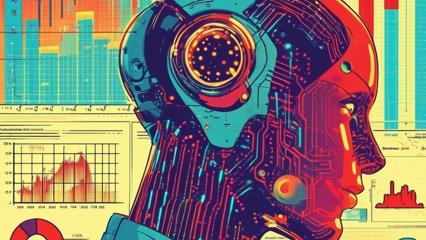

[6 bit questions about AI.](https://venturebeat.com/ai/from-agi-to-roi-the-6-ai-debates-shaping-enterprise-strategy-in-2024/) - VentureBeat

___

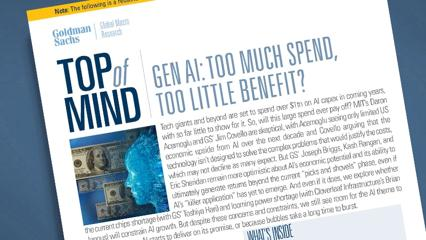

[Goldman Sachs on Gen AI: too much spend, too little benefit?](https://www.goldmansachs.com/intelligence/pages/gen-ai-too-much-spend-too-little-benefit.html) - Goldman Sachs

___

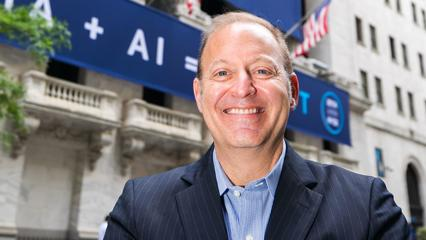

[AI economic indicator combines high-frequency and low-frequency data in an opaque and useless way.](https://www.cnbc.com/2024/07/01/a-new-index-is-using-ai-tools-to-measure-us-economic-growth-in-a-broader-way.html#:~:text=do%20the%20job.-,The%20Zeta%20Economic%20Index%2C%20launched%20Monday%2C%20uses%20generative%20AI%20to,a%20separate%20measure%20on%20stability) - CNBC

___

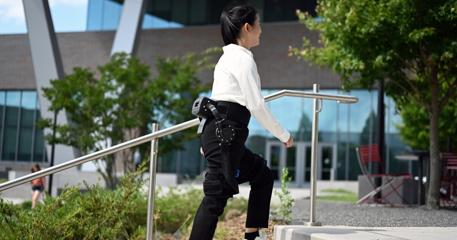

[Lower-body AI exoskeleton trained on videos assists people  walking, running, climbing stairs, reduces energy needed by 13% to 24%.](https://www.wunc.org/news/2024-06-28/nc-state-ai-robotic-exoskeleton-simulation) - WUNC

___

[Steve Ballmer is now richer than Bill Gates, as Ballmer kept his Microsoft stock while Gates heeded Buffett's advice to diversify. Fun fact, Ballmer margined his stock and levered up when Microsoft Word was delayed in the 80s and the stock took a big hit, increased his net worth maybe 30%.](https://www.bloomberg.com/news/articles/2024-07-01/ballmer-is-richer-than-gates-a-first-for-microsoft-billionaires)

___

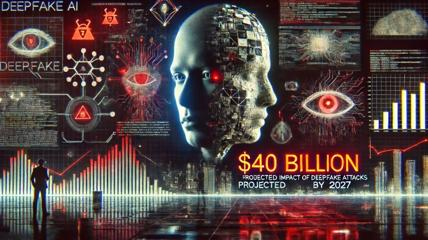

[Enterprises are unprepared for a wave of deepfake identity fraud.](https://venturebeat.com/security/deepfakes-will-cost-40-billion-by-2027-as-adversarial-ai-gains-momentum/) - VentureBeat

___

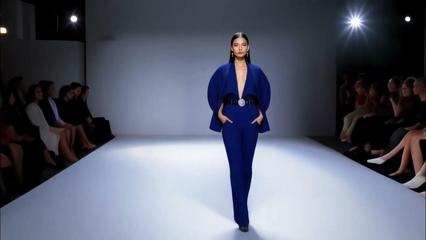

[Motorola / Lenovo positions phone as a fashion item with AI-generated ad.](https://www.youtube.com/watch?v=CSfw_NjqQ2o) - YouTube

___

[Rehabilitate or reprogram criminals by implanting false memories. wut?](https://wired.me/technology/cognify-prison-of-future/)

___

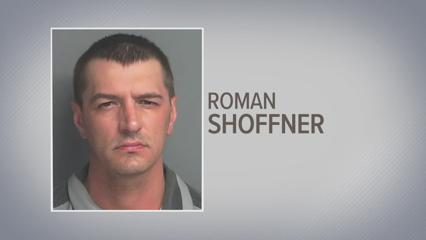

[Texas man catches a child porn charge over deepfake.](https://www.khou.com/article/news/crime/texas-man-child-pornography-charges-artificial-intelligence/285-53d74767-dea7-42b9-b651-f0cd0712ebc9) - khou.com

___

[Ukraine, the Silicon Valley of killer robots.](https://www.nytimes.com/2024/07/02/technology/ukraine-war-ai-weapons.html)

___

[YouTube implements process to take down AI deepfakes.](https://www.theregister.com/2024/07/02/youtube_deepfake_privacy_rules/)

___

[Figure posts video of its robot, says it's up and running at US BMW plant.](https://x.com/Figure_robot/status/1807814184299831749) - X (formerly Twitter)

___

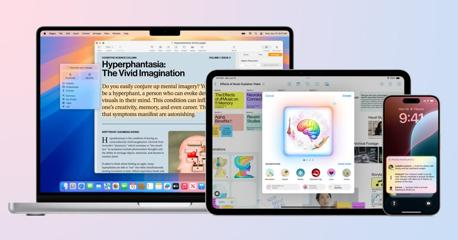

[Apple still in talks with Google and also Anthropic for AI integration, probably not Meta](https://9to5mac.com/2024/07/01/apple-google-gemini-chatbot/) - 9to5Mac

___

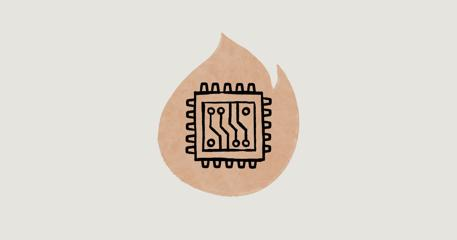

[Anthropic wants to fund evals for LLM quality and safety, and tooling around evals.](https://www.anthropic.com/news/a-new-initiative-for-developing-third-party-model-evaluations?utm_source=bensbites&utm_medium=referral&utm_campaign=anthropic-s-throwing-cash-at-third-party-ai-evaluations)

___

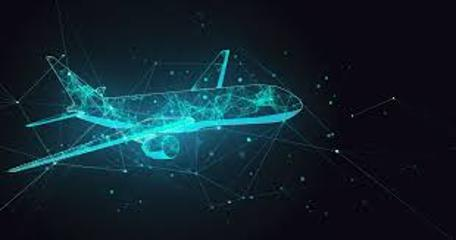

[FAA asking for comments on using AI to improve flight safety.](https://www.avweb.com/aviation-news/faa-looking-for-ai-help-with-flight-safety/) - AVweb

___

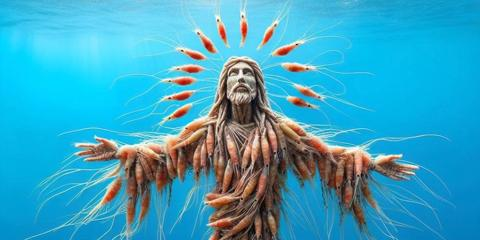

[AI updates 'made with AI' labels to 'AI info' after creators complained about false positives. Why doesn't Facebook just ban 'Shrimp Jesus' and similar monstrosities? Engagement.](https://www.businessinsider.com/meta-facebook-ban-ai-slop-images-shrimp-jesus-why-2024-6?utm_source=reddit.com) - Business Insider

___

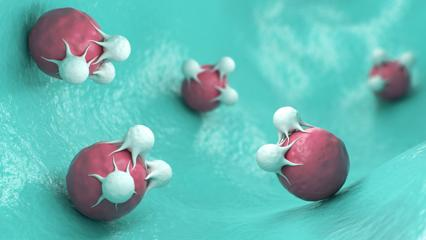

[Nanobots hunt cancer cells.](https://interestingengineering.com/health/nanorobots-target-cancer-spare-healthy-cells) - Interesting Engineering

___

[Adi Samir, who is the S in RSA, has a paper about how to extract weights from a neural network. Unclear how practical it would be to extract all the weights in GPT-4o.](https://www.schneier.com/blog/archives/202/07/model-extraction-from-neural-networks.html)

___

[MIT robots gently pack groceries, including delicate like soft fruits (video at bottom)](https://www.therobotreport.com/robogrocery-from-mit-csail-is-a-soft-robot-to-pack-groceries-pick-recyclables/)

___

(I'm sure there will never be a glut though. 🙄😂)

[SK Hynix has sold out its dense VRAM through late 2025, looking to invest \\$75b to increase capacity.](https://www.theregister.com/2024/07/01/sk_hynix_hbm_investment/)

___

[Using AI to measure carbon emissions. Physician, heal thyself!](https://www.esgtoday.com/co2-ai-launches-generative-ai-powered-product-emissions-assessment-solution/)

___

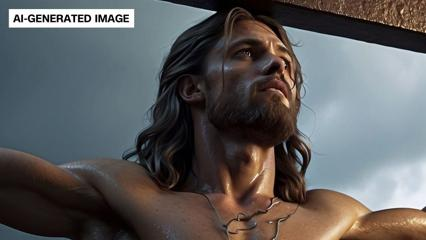

[AI Jesus images considered inaccurate. You mean he wasn't blond-haired, blue-eyed and ripped? As if every culture didn't depict Jesus with the features of the most appealing local hunks.](https://www.cnn.com/2024/07/01/style/jesus-ai-artificial-intelligence-social-media-cec) - CNN

___

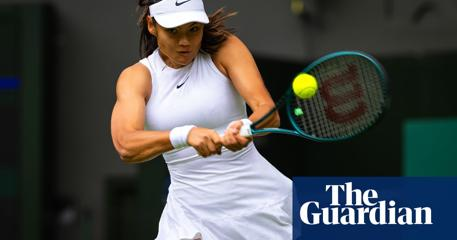

[Wimbledon's AI news ticker erroneously refers to Raducanu as UK #1 when she is #3. Hopefully they spelled her name right.](https://www.theguardian.com/sport/article/2024/jul/01/ai-writer-served-by-wimbledon-and-ibm-commits-double-fault) - the Guardian

___

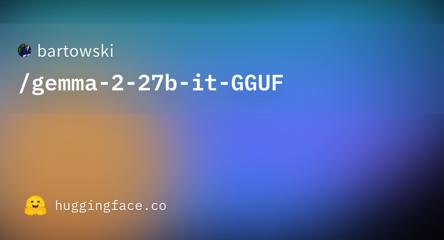

[A recent development is that the latest Google Gemma 27b-parameter model ranks above early GPT-4 releases in LMSYS, coming in tied for 12th overall. You should be able to run this on a beefy MacBook Pro or any 24GB GPU . Just grab LM Studio and search this URL.](https://huggingface.co/bartowski/gemma-2-27b-it-GGUF)

___

[French set bring antitrust changes against Nvidia. Jensen, wyd?](https://www.reuters.com/technology/french-antitrust-regulators-preparing-nvidia-charges-sources-say-2024-07-01/)

___

[The gold is not in the chips, but the data.](https://www.reuters.com/breakingviews/economics-ai-points-value-good-data-2024-06-28/)

___

[Apple gonna charge for some AI features, natch. I would pay like \\$20 for the top tier of Apple One but \\$40 is bonkers, sorry, I guess I'm a cheapskate.](https://www.bloomberg.com/news/newsletters/2024-06-30/apple-s-longer-lasting-devices-ios-19-and-apple-intelligence-on-the-vision-pro-ly1jnrw4)

___

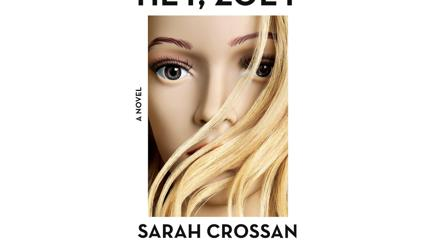

[A Stepford Wives update for the age of AI?](https://abcnews.go.com/Technology/wireStory/book-review-hey-zoey-questions-ai-womens-autonomy-111578343) - ABC News

___

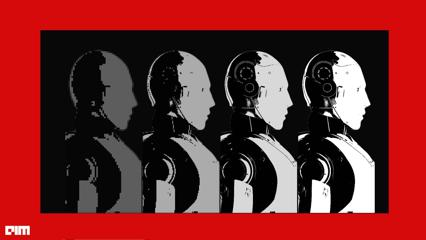

[‘There is No Economic Incentive for AI to Kill Humans,’ says Illia Polosukhin. That's a relief. But wait, do robots respond to economic incentives? That's the crux of the problem, figuring out proper training and incentive structures that won't cause them to go wild.](https://analyticsindiamag.com/there-is-no-economic-incentive-for-ai-to-kill-humans-said-illia-polosukhin-co-author-of-the-transformer-paper/) - Analytics India Magazine

___

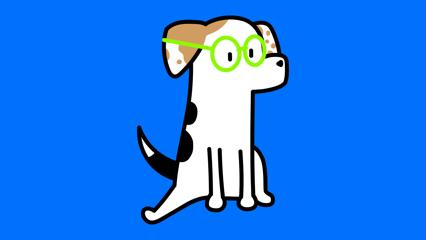

[An AI simulator to prep for YC interviews.](https://blog.lytix.co/posts/yc-interviewer-bot) - lytix Blog

___

[A list of words AI might overuse.](https://www.reddit.com/r/ChatGPT/comments/1dsjyp5/i_made_a_list_of_100_words_phrases_that_chatgpt/)

___

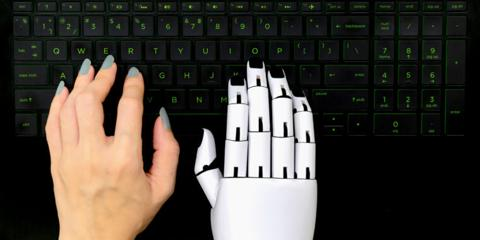

[Delving into telltale AI words](https://arstechnica.com/ai/2024/07/the-telltale-words-that-could-identify-generative-ai-text/) - Ars Technica

___

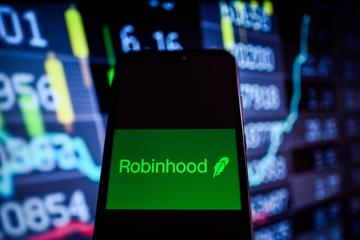

[Robinhood acquires Pluto AI tools startup to enhance its platform.](https://techcrunch.com/2024/07/01/robinhood-snaps-up-pluto-to-add-ai-tools-to-its-investing-app/) - TechCrunch

___

[Big Tech races to lock up nuclear power.](https://www.wsj.com/business/energy-oil/tech-industry-wants-to-lock-up-nuclear-power-for-ai-6cb75316)

___

[Dating apps turn to AI as users get burned out.](https://www.fastcompany.com/91149035/online-dating-app-burnout-artificial-intelligence-tinder-grindr-hinge-bumble)

___

AI is still only a small part of the story but it's increasing rapidly.

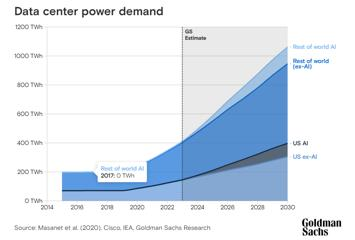

[A lot is at stake in the race to build cloud and AI and the power infrastructure.](https://prospect.org/environment/2024-07-01-unknown-toll-of-ai-takeover/) - The American Prospect

___

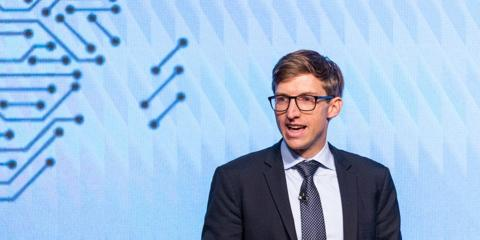

[Taiwan is a critical link in the AI supply chain and China is rattling sabers pretty hard, while US  is trying to strangle China's AI tech. It's bad, and Ukraine shows that increasing economic integration and self-interest is not always sufficient to make everyone disposed to co-operate peacefully.](https://www.businessinsider.com/ai-taiwan-china-chip-war-2024-6) - Business Insider

___

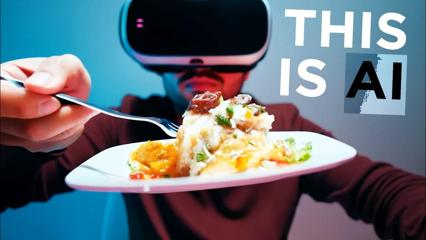

[Runway Gen 3 looks pretty cray](https://www.youtube.com/watch?v=_L673Wje6jo) - YouTube

___

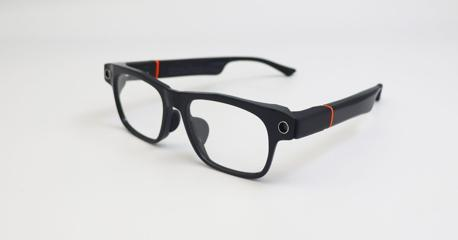

[Smart glasses making a comeback?](https://9to5google.com/2024/06/30/solos-airgo-vision-smart-glasses-gemini/) - 9to5Google

___

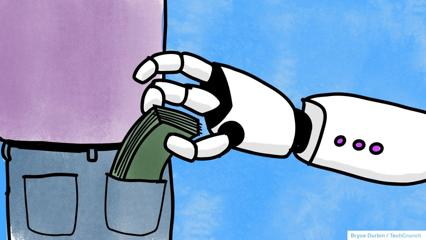

[Multiplying AI-powered scams to be on the lookout for.](https://techcrunch.com/2024/06/30/ai-powered-scams-and-what-you-can-do-about-them/) - TechCrunch

___

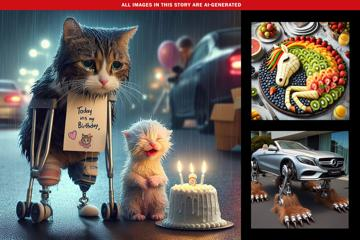

[Surrealism, or AI slop?](https://www.washingtonpost.com/style/of-interest/2024/06/30/ai-art-facebook-slop-artificial-intelligence/) - Washington Post

___

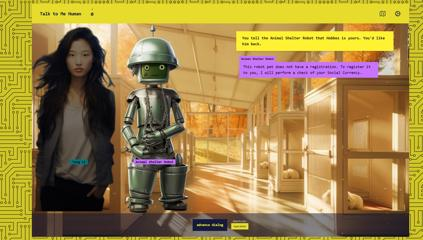

[An LLM-based game you can talk fast to](https://readwrite.com/you-havent-played-anything-like-this-before-but-maybe-talk-to-me-human-is-a-sneak-peek-into-how-npcs-in-games-will-all-be-done-soon/) - ReadWrite

___

[Today in nightmare fuel  / mad scientists high as a kite on cocaine... doesn't anyone around here listen to Jeff Goldblum?](https://www.nytimes.com/2024/06/30/science/japan-robots-human-face.html)

___

Superhuman AI, but just for turning the universe into Morgan Freeman memes instead of paperclips.

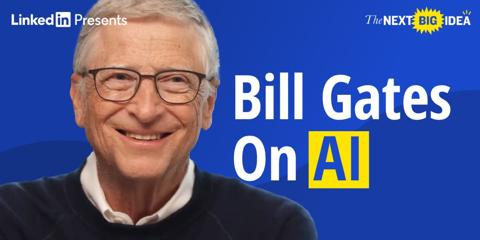

[Bill Gates podcast, says superhuman AI might be closer than you think.](https://nextbigideaclub.com/magazine/bill-gates-says-superhuman-ai-may-closer-think-podcast/50267/) - Next Big Idea Club

___

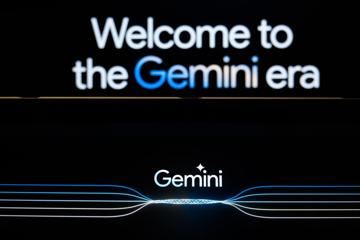

[Google's long-context models aren't as good at understanding long texts as Google claims.](https://techcrunch.com/2024/06/29/geminis-data-analyzing-abilities-arent-as-good-as-google-claims/) - TechCrunch

___

Some characters could not be decoded, and were replaced with REPLACEMENT CHARACTER.


[AI experiences developer burnout](https://i.redd.it/eeb0r6bo3k9d1.png)

___

Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)

In [10]:
imgdir = 'tmp'  # for images
delete_files(imgdir)

display(Markdown("\n x <br /> \n"))

display(Markdown("\n <br /> \n"))

for i, post in enumerate(data.feed):


    # check date
    date_str = data.feed[0].post.record.created_at
    dt = datetime.fromisoformat(date_str.rstrip('Z'))
    # break if more than 30 hours ago
    if dt  < datetime.now() - timedelta(hours=30):
        break
    
    post_str = post.post.record.text.rstrip()
    post_str = truncate_last_occurrence(post_str)
    post_url = ""
    tag_dict = {}
    try:
        post_url = post.post.record.embed.external.uri.rstrip()
    except:
        pass
    if post_url:
        tag_dict = dict()
        try:
            tag_dict = get_og_tags(post_url)
        except:
            pass
        display_str = f"[{post_str}]({post_url})"
        site_name = tag_dict.get('og:site_name')
        img_url = tag_dict.get('og:image')
        if site_name:
            display_str += f" - {site_name}"

        display_str = display_str.replace("$", "\\\$")  # so Markdown doesn't interpret $ as latex escape
        if img_url:
            try:
                r = rawfetchurl(img_url)
                content_type = r.headers['Content-Type']
                content_type = content_type[content_type.find('/')+1:]
                impath = f"{imgdir}/source{i}.{content_type}"
                with open(impath, 'wb') as file:
                    file.write(r.content)
                output_path = f'{imgdir}/Image{i}.jpg'
                resize_and_crop(impath, output_path)
                display(IPython.display.Image(filename=output_path))
            except Exception as e:
                print(e)
        display(Markdown(display_str))
        display(Markdown("___"))

    else:
        display(Markdown(f"{post_str}"))

display(Markdown(f"Follow the latest AI headlines via [SkynetAndChill.com on Bluesky](https://bsky.app/profile/skynetandchill.com)"))

        

In [11]:
date_str = data.feed[0].post.record.created_at
dt = datetime.fromisoformat(date_str.rstrip('Z'))
dt

datetime.datetime(2024, 7, 2, 15, 58, 7, 675000)

In [12]:

# Get the current datetime
now = datetime.now()

# Create a timedelta of 30 hours
delta = timedelta(hours=30)

# Subtract 30 hours from the current datetime
thirty_hours_ago = now - delta

print(thirty_hours_ago)


2024-07-01 06:01:30.736266
